# Weather Forecasting with a Seq2Seq Transformer (Colab)
This notebook trains a **multivariate time-series Transformer** to forecast weather (e.g., **T2M**) for Vietnam & the East Sea dataset.

**Highlights**
- Robust preprocessing (scaling, seasonality features, per-location series id).
- Seq2Seq Transformer (PyTorch), teacher forcing.
- Train/Val/Test split by time.
- Visualizations: EDA, correlation, learning curves, predictions vs. ground truth.
- Easy configuration via **Colab form fields**.


In [11]:
#@title ⬇️ Install dependencies
# (Colab often has these, but this cell ensures availability)
!pip install pandas numpy scikit-learn tqdm matplotlib torch torchvision
# PyTorch is preinstalled on Colab; uncomment to force a specific CUDA build if needed
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [1]:
import argparse, os, math, random, json
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler


SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [2]:
CSV_PATH = r"/mnt/e/pbl7/datatrainai_filled.csv" 
TARGETS = "T2M"              
HORIZON = 7                  
WINDOW = 180                 
BATCH_SIZE = 64              
D_MODEL = 256               
HEADS = 8                    
LAYERS = 4                   
FF = 1024                    
DROPOUT = 0.1                
LR = 3e-4                    
WEIGHT_DECAY = 1e-2         
MAX_EPOCHS = 50              
PATIENCE = 7                 
NUM_WORKERS = 2              
TRAIN_END = "2022-12-31"     
VALID_END = "2024-12-31"     
TARGET_LIST = [t.strip() for t in TARGETS.split(",") if t.strip()]
print("Targets:", TARGET_LIST)

Targets: ['T2M']


In [3]:
USE_UPLOAD = False
USE_DRIVE = False  

if USE_UPLOAD:
    try:
        from google.colab import files
        up = files.upload()
        print("Uploaded files:", list(up.keys()))
    except Exception as e:
        print("Upload not available (not running in Colab).", e)

if USE_DRIVE:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Drive mounted. You can set CSV_PATH to a file in /content/drive.")
    except Exception as e:
        print("Drive mount not available (not running in Colab).", e)


In [4]:
def series_id(lat, lon, prec=3):
    return f"{round(float(lat),prec)}_{round(float(lon),prec)}"

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["Latitude", "Longitude", "date"]).reset_index(drop=True)
    doy = df["date"].dt.dayofyear.values
    df["doy_sin"] = np.sin(2*np.pi*doy/365.25)
    df["doy_cos"] = np.cos(2*np.pi*doy/365.25)
    mon = df["date"].dt.month.values
    df["mon_sin"] = np.sin(2*np.pi*mon/12.0)
    df["mon_cos"] = np.cos(2*np.pi*mon/12.0)
    df["sid"] = [series_id(a,b) for a,b in zip(df["Latitude"], df["Longitude"])]
    return df

def time_split_by_date(df: pd.DataFrame, date_col="date",
                       train_end="2022-12-31", valid_end="2024-12-31"):
    train = df[df[date_col] <= pd.to_datetime(train_end)].copy()
    valid = df[(df[date_col] > pd.to_datetime(train_end)) &
               (df[date_col] <= pd.to_datetime(valid_end))].copy()
    test  = df[df[date_col] > pd.to_datetime(valid_end)].copy()
    return train, valid, test


In [5]:
class WindowDataset(Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 feature_cols: List[str],
                 target_cols: List[str],
                 window: int,
                 horizon: int,
                 sid_col: str = "sid"):
        self.df = df
        self.feature_cols = feature_cols
        self.target_cols  = target_cols
        self.window = window
        self.horizon = horizon
        self.sid_col = sid_col

        self.groups = []
        for sid, g in df.groupby(sid_col):
            g = g.sort_values("date")
            values = g.reset_index(drop=True)
            for i in range(len(values) - (window + horizon) + 1):
                self.groups.append((sid, i, values))

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        sid, i, g = self.groups[idx]
        sl = slice(i, i + self.window)
        tl = slice(i + self.window, i + self.window + self.horizon)
        x = g.loc[sl, self.feature_cols].values.astype(np.float32)
        y = g.loc[tl, self.target_cols].values.astype(np.float32)
        y_in = np.zeros_like(y); y_in[1:] = y[:-1]
        return torch.from_numpy(x), torch.from_numpy(y_in), torch.from_numpy(y)


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 3700, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        T = x.size(0)
        x = x + self.pe[:T]
        return self.dropout(x)

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 d_input: int,
                 d_output: int,
                 d_model: int = 256,
                 nhead: int = 8,
                 num_encoder_layers: int = 4,
                 num_decoder_layers: int = 4,
                 dim_feedforward: int = 1024,
                 dropout: float = 0.1):
        super().__init__()
        self.src_proj = nn.Linear(d_input, d_model)
        self.tgt_proj = nn.Linear(d_output, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout)
        self.pos_dec = PositionalEncoding(d_model, dropout=dropout)
        self.transformer = nn.Transformer(d_model=d_model,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout,
                                          batch_first=False)
        self.head = nn.Linear(d_model, d_output)

    def generate_square_subsequent_mask(self, size: int, device):
        mask = torch.triu(torch.ones(size, size, device=device) * float('-inf'), diagonal=1)
        return mask

    def forward(self, src: torch.Tensor, tgt_in: torch.Tensor):
        src = self.src_proj(src)
        tgt = self.tgt_proj(tgt_in)
        src = src.transpose(0,1)
        tgt = tgt.transpose(0,1)
        src = self.pos_enc(src)
        tgt = self.pos_dec(tgt)
        device = src.device
        H = tgt.size(0)
        tgt_mask = self.generate_square_subsequent_mask(H, device)
        out = self.transformer(src, tgt, tgt_mask=tgt_mask)
        out = self.head(out)
        return out.transpose(0,1)


In [7]:
@dataclass
class Config:
    csv: str
    target: List[str]
    window: int
    horizon: int
    batch_size: int
    d_model: int
    heads: int
    layers: int
    ff: int
    dropout: float
    lr: float
    weight_decay: float
    max_epochs: int
    patience: int
    num_workers: int

def make_feature_target_cols(df: pd.DataFrame, targets: List[str]) -> Tuple[List[str], List[str]]:
    cols = ["T2M","QV2M","PS","WS10M","PRECTOTCORR","CLRSKY_SFC_SW_DWN",
            "Latitude","Longitude","hour","day","month","doy_sin","doy_cos","mon_sin","mon_cos"]
    cols = [c for c in cols if c in df.columns]
    target_cols = targets
    feature_cols = cols
    return feature_cols, target_cols

def build_scalers(train_df, feature_cols, target_cols):
    Xs, Ys = train_df[feature_cols].values, train_df[target_cols].values
    x_scaler, y_scaler = StandardScaler(), StandardScaler()
    x_scaler.fit(Xs); y_scaler.fit(Ys)
    return x_scaler, y_scaler

def apply_scalers(df, feature_cols, target_cols, x_scaler, y_scaler):
    df = df.copy()
    df[feature_cols] = x_scaler.transform(df[feature_cols].values)
    df[target_cols]  = y_scaler.transform(df[target_cols].values)
    return df

def collate(batch):
    xs, ys_in, ys = zip(*batch)
    return torch.stack(xs,0), torch.stack(ys_in,0), torch.stack(ys,0)

def mae_rmse(y_true, y_pred):
    mae = (y_true - y_pred).abs().mean().item()
    rmse = torch.sqrt(torch.mean((y_true - y_pred)**2)).item()
    return mae, rmse

def train_loop(model, loader, opt, scaler_amp, device, use_amp=True):
    model.train()
    total_loss = 0.0
    crit = nn.MSELoss()
    amp_dtype = torch.float16 if device.type == "cuda" else torch.bfloat16
    for x, y_in, y in loader:
        x, y_in, y = x.to(device), y_in.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device.type, dtype=amp_dtype, enabled=use_amp):
            out = model(x, y_in)
            loss = crit(out, y)
        scaler_amp.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler_amp.step(opt)
        scaler_amp.update()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_loop(model, loader, device):
    model.eval()
    crit = nn.MSELoss()
    total_loss = 0.0
    mae_total, rmse_total, n = 0.0, 0.0, 0
    for x, y_in, y in loader:
        x, y_in, y = x.to(device), y_in.to(device), y.to(device)
        out = model(x, y_in)
        loss = crit(out, y)
        total_loss += loss.item() * x.size(0)
        mae, rmse = mae_rmse(y, out)
        mae_total += mae * x.size(0)
        rmse_total += rmse * x.size(0)
        n += x.size(0)
    return total_loss / len(loader.dataset), mae_total/n, rmse_total/n


Raw shape: (1695456, 13)
Filled NAs: 104951 -> 0


,date,Latitude,Longitude,T2M,QV2M,PS,WS10M,PRECTOTCORR,CLRSKY_SFC_SW_DWN,hour,day,month,season,doy_sin,doy_cos,mon_sin,mon_cos,sid
211932,2020-10-02,10.0,102.0,28.42,20.01,100.74,6.50,13.12,24.23,0,2,10,4,-0.999371,0.035473,-0.866025,0.5,10.0_102.0
211933,2020-10-03,10.0,102.0,27.74,20.18,100.83,4.92,26.41,23.80,0,3,10,4,-0.998613,0.052658,-0.866025,0.5,10.0_102.0
211934,2020-10-04,10.0,102.0,27.95,19.99,100.92,4.77,13.72,24.19,0,4,10,4,-0.997559,0.069828,-0.866025,0.5,10.0_102.0
211935,2020-10-05,10.0,102.0,28.01,19.56,100.86,3.00,7.50,24.51,0,5,10,4,-0.996210,0.086977,-0.866025,0.5,10.0_102.0
211936,2020-10-06,10.0,102.0,28.22,19.67,100.83,4.31,5.26,23.81,0,6,10,4,-0.994567,0.104101,-0.866025,0.5,10.0_102.0


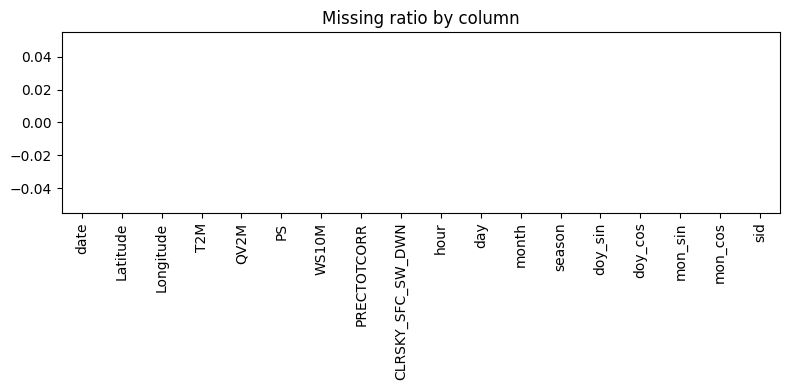

Top SID: 9.5_109.5  | length: 1827


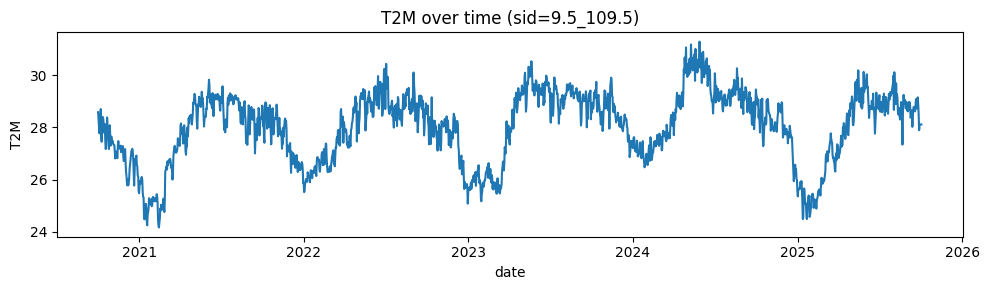

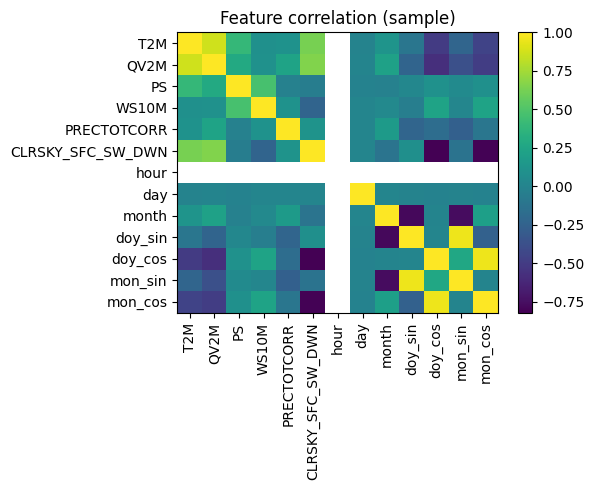

Split sizes: 761888 678368 255200
Feature cols: ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOTCORR', 'CLRSKY_SFC_SW_DWN', 'Latitude', 'Longitude', 'hour', 'day', 'month', 'doy_sin', 'doy_cos', 'mon_sin', 'mon_cos']
Target cols: ['T2M']


In [8]:
df = pd.read_csv(CSV_PATH)
print("Raw shape:", df.shape)
df = add_time_features(df)

id_cols = ["Latitude","Longitude"]
df["sid"] = [f"{round(float(a),3)}_{round(float(b),3)}" for a,b in zip(df["Latitude"], df["Longitude"])]
df = df.sort_values(["sid","date"])
num_na_before = df.isna().sum().sum()
for c in ["T2M","QV2M","PS","WS10M","PRECTOTCORR","CLRSKY_SFC_SW_DWN","hour","day","month","doy_sin","doy_cos","mon_sin","mon_cos"]:
    if c in df.columns:
        df[c] = df.groupby("sid")[c].ffill().bfill()
num_na_after = df.isna().sum().sum()
print(f"Filled NAs: {num_na_before} -> {num_na_after}")

display(df.head())

na_ratio = df.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
na_ratio.plot(kind="bar")
plt.title("Missing ratio by column")
plt.tight_layout()
plt.show()

sid_counts = df["sid"].value_counts()
top_sid = sid_counts.index[0]
print("Top SID:", top_sid, " | length:", sid_counts.iloc[0])

if "T2M" in df.columns:
    g = df[df["sid"] == top_sid]
    plt.figure(figsize=(10,3))
    plt.plot(g["date"].values, g["T2M"].values)
    plt.title(f"T2M over time (sid={top_sid})")
    plt.xlabel("date"); plt.ylabel("T2M")
    plt.tight_layout()
    plt.show()

corr_cols = [c for c in ["T2M","QV2M","PS","WS10M","PRECTOTCORR","CLRSKY_SFC_SW_DWN","hour","day","month","doy_sin","doy_cos","mon_sin","mon_cos"] if c in df.columns]
sample = df[corr_cols].dropna()
if len(sample) > 20000:
    sample = sample.sample(20000, random_state=SEED)
corr = sample.corr(numeric_only=True)
plt.figure(figsize=(6,5))
plt.imshow(corr.values, aspect="auto", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Feature correlation (sample)")
plt.tight_layout()
plt.show()

train_df, valid_df, test_df = time_split_by_date(df, "date",
                                                 train_end=TRAIN_END,
                                                 valid_end=VALID_END)
print("Split sizes:", len(train_df), len(valid_df), len(test_df))

feature_cols, target_cols = (lambda d: (
    [c for c in ["T2M","QV2M","PS","WS10M","PRECTOTCORR","CLRSKY_SFC_SW_DWN",
                 "Latitude","Longitude","hour","day","month","doy_sin","doy_cos","mon_sin","mon_cos"]
     if c in d.columns],
    TARGET_LIST
))(df)
print("Feature cols:", feature_cols)
print("Target cols:", target_cols)

x_scaler, y_scaler = StandardScaler(), StandardScaler()
x_scaler.fit(train_df[feature_cols].values)
y_scaler.fit(train_df[target_cols].values)

train_df_ = train_df.copy()
valid_df_ = valid_df.copy()
test_df_  = test_df.copy()

train_df_[feature_cols] = x_scaler.transform(train_df_[feature_cols].values)
train_df_[target_cols]  = y_scaler.transform(train_df_[target_cols].values)
valid_df_[feature_cols] = x_scaler.transform(valid_df_[feature_cols].values)
valid_df_[target_cols]  = y_scaler.transform(valid_df_[target_cols].values)
test_df_[feature_cols]  = x_scaler.transform(test_df_[feature_cols].values)
test_df_[target_cols]   = y_scaler.transform(test_df_[target_cols].values)


In [9]:
ds_tr = WindowDataset(train_df_, feature_cols, target_cols, WINDOW, HORIZON)
ds_va = WindowDataset(valid_df_, feature_cols, target_cols, WINDOW, HORIZON)
ds_te = WindowDataset(test_df_,  feature_cols, target_cols, WINDOW, HORIZON)
print("Windows:", len(ds_tr), len(ds_va), len(ds_te))

dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,
                   num_workers=NUM_WORKERS, collate_fn=lambda b: (torch.stack([x for x,_,_ in b]), torch.stack([y for _,y,_ in b]), torch.stack([z for *_,z in b])),
                   pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False,
                   num_workers=NUM_WORKERS, collate_fn=lambda b: (torch.stack([x for x,_,_ in b]), torch.stack([y for _,y,_ in b]), torch.stack([z for *_,z in b])),
                   pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False,
                   num_workers=NUM_WORKERS, collate_fn=lambda b: (torch.stack([x for x,_,_ in b]), torch.stack([y for _,y,_ in b]), torch.stack([z for *_,z in b])),
                   pin_memory=True)

xb, yb_in, yb = next(iter(dl_tr))
print("xb shape:", xb.shape, "| y_in:", yb_in.shape, "| y:", yb.shape)


Windows: 589280 505760 82592
xb shape: torch.Size([64, 181, 15]) | y_in: torch.Size([64, 8, 1]) | y: torch.Size([64, 8, 1])


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = Seq2SeqTransformer(
    d_input=len(feature_cols),
    d_output=len(target_cols),
    d_model=D_MODEL,
    nhead=HEADS,
    num_encoder_layers=LAYERS,
    num_decoder_layers=LAYERS,
    dim_feedforward=FF,
    dropout=DROPOUT
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def lr_lambda(step):
    warmup = 2000
    total_steps = max(1, MAX_EPOCHS*max(1, len(dl_tr)) - warmup)
    if step < warmup:
        return float(step) / float(warmup)
    progress = (step - warmup) / float(total_steps)
    return 0.5 * (1.0 + math.cos(math.pi * min(1.0, max(0.0, progress))))

sch = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)

use_amp = (device.type == "cuda")
scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp)

def run_train_epoch():
    model.train()
    crit = nn.MSELoss()
    total_loss = 0.0
    amp_dtype = torch.float16 if device.type == "cuda" else torch.bfloat16
    for x, y_in, y in dl_tr:
        x, y_in, y = x.to(device), y_in.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device.type, dtype=amp_dtype, enabled=use_amp):
            out = model(x, y_in)
            loss = crit(out, y)
        scaler_amp.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler_amp.step(opt)
        scaler_amp.update()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(ds_tr)

@torch.no_grad()
def run_eval_epoch(loader):
    model.eval()
    crit = nn.MSELoss()
    total_loss = 0.0
    mae_total = 0.0
    rmse_total = 0.0
    n = 0
    for x, y_in, y in loader:
        x, y_in, y = x.to(device), y_in.to(device), y.to(device)
        out = model(x, y_in)
        loss = crit(out, y)
        total_loss += loss.item() * x.size(0)
        mae = (y - out).abs().mean().item()
        rmse = torch.sqrt(torch.mean((y - out)**2)).item()
        mae_total += mae * x.size(0)
        rmse_total += rmse * x.size(0)
        n += x.size(0)
    return total_loss/len(loader.dataset), mae_total/n, rmse_total/n

history = {"train_mse": [], "val_mse": [], "val_mae": [], "val_rmse": []}
best_val = float("inf")
pat = PATIENCE
ckpt_path = "best_transformer.pt"

global_step = 0
for epoch in range(1, MAX_EPOCHS+1):
    train_mse = run_train_epoch()
    sch.step()
    val_mse, val_mae, val_rmse = run_eval_epoch(dl_va)
    history["train_mse"].append(train_mse)
    history["val_mse"].append(val_mse)
    history["val_mae"].append(val_mae)
    history["val_rmse"].append(val_rmse)
    print(f"Epoch {epoch:03d} | train MSE {train_mse:.5f} | val MSE {val_mse:.5f} | val MAE {val_mae:.5f} | val RMSE {val_rmse:.5f}")
    if val_mse < best_val - 1e-6:
        best_val = val_mse
        torch.save({"model": model.state_dict(),
                    "x_scaler_mean": x_scaler.mean_.tolist(),
                    "x_scaler_scale": x_scaler.scale_.tolist(),
                    "y_scaler_mean": y_scaler.mean_.tolist(),
                    "y_scaler_scale": y_scaler.scale_.tolist(),
                    "feature_cols": feature_cols,
                    "target_cols": target_cols,
                    "cfg": {
                        "WINDOW": WINDOW, "HORIZON": HORIZON, "D_MODEL": D_MODEL, "HEADS": HEADS,
                        "LAYERS": LAYERS, "FF": FF, "DROPOUT": DROPOUT
                    }}, ckpt_path)
        pat = PATIENCE
        print("  ✅ Saved best to", ckpt_path)
    else:
        pat -= 1
        if pat == 0:
            print("  ⏹ Early stopping.")
            break

plt.figure(figsize=(6,3))
plt.plot(history["train_mse"], label="train MSE")
plt.plot(history["val_mse"], label="val MSE")
plt.legend(); plt.title("Learning curves (MSE)"); plt.xlabel("epoch"); plt.ylabel("MSE")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(history["val_mae"], label="val MAE")
plt.plot(history["val_rmse"], label="val RMSE")
plt.legend(); plt.title("Validation metrics"); plt.xlabel("epoch")
plt.tight_layout(); plt.show()


Device: cuda


/home/phangiabo-1170/ml/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_362845/1082390811.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp)


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/phangiabo-1170/ml/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/phangiabo-1170/ml/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_362845/3819720841.py", line 7, in <lambda>
    num_workers=NUM_WORKERS, collate_fn=lambda b: (torch.stack([x for x,_,_ in b]), torch.stack([y for _,y,_ in b]), torch.stack([z for *_,z in b])),
                                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [8, 1] at entry 0 and [7, 1] at entry 23


In [ ]:

ckpt = torch.load("best_transformer.pt", map_location=device)
model.load_state_dict(ckpt["model"])

@torch.no_grad()
def eval_loader(loader):
    model.eval()
    crit = nn.MSELoss()
    total_loss = 0.0; mae_total = 0.0; rmse_total = 0.0; n = 0
    for x, y_in, y in loader:
        x, y_in, y = x.to(device), y_in.to(device), y.to(device)
        out = model(x, y_in)
        loss = crit(out, y)
        total_loss += loss.item() * x.size(0)
        mae = (y - out).abs().mean().item()
        rmse = torch.sqrt(torch.mean((y - out)**2)).item()
        mae_total += mae * x.size(0); rmse_total += rmse * x.size(0); n += x.size(0)
    return total_loss/len(loader.dataset), mae_total/n, rmse_total/n

test_mse, test_mae, test_rmse = eval_loader(dl_te)
print(f"TEST | MSE {test_mse:.5f} | MAE {test_mae:.5f} | RMSE {test_rmse:.5f}")

x, y_in, y_true = next(iter(dl_te))
x = x.to(device); y_in = y_in.to(device); y_true = y_true.to(device)
y_pred = model(x, y_in)

tgt_idx = 0
first_pred = y_pred[0].cpu().numpy()[:, tgt_idx]
first_true = y_true[0].cpu().numpy()[:, tgt_idx]

y_mean = y_scaler.mean_[tgt_idx]; y_scale = y_scaler.scale_[tgt_idx]
first_pred_denorm = first_pred * y_scale + y_mean
first_true_denorm = first_true * y_scale + y_mean

plt.figure(figsize=(8,3))
plt.plot(first_true_denorm, label="ground truth")
plt.plot(first_pred_denorm, label="prediction")
plt.title(f"Sample horizon forecast (target={target_cols[tgt_idx]})")
plt.xlabel("horizon step"); plt.ylabel("value")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
def forecast_for_sid(raw_df, sid: str, window: int = WINDOW, horizon: int = HORIZON):
    g = raw_df[raw_df["sid"]==sid].sort_values("date").reset_index(drop=True)
    if len(g) < window + horizon:
        raise ValueError(f"Series {sid} too short: {len(g)} rows")
    X_last = g.iloc[-(window+horizon):].copy()  
    X_last_feat = X_last.iloc[:window][feature_cols].values.astype(np.float32)
    X_last_feat = x_scaler.transform(X_last_feat)
    X_last_feat = torch.from_numpy(X_last_feat).unsqueeze(0)  
    y_in = torch.zeros((1, horizon, len(target_cols)), dtype=torch.float32)
    with torch.no_grad():
        X_last_feat = X_last_feat.to(device)
        y_in = y_in.to(device)
        out = model(X_last_feat, y_in).cpu().numpy()[0]  
    out_denorm = out.copy()
    for j in range(len(target_cols)):
        out_denorm[:, j] = out[:, j]*y_scaler.scale_[j] + y_scaler.mean_[j]
    return out_denorm

try:
    preds = forecast_for_sid(df, top_sid, WINDOW, HORIZON)
    plt.figure(figsize=(8,3))
    plt.plot(preds[:,0])
    plt.title(f"Forecast for sid={top_sid} (target={target_cols[0]})")
    plt.xlabel("horizon step"); plt.ylabel("value")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Inference example skipped:", e)


In [ ]:
SAVE_TO_DRIVE = False 
SAVE_DIR = "/content/drive/MyDrive/weather_transformer" #chỉnh lại đường dẫn máy nha phan bảo đần
if SAVE_TO_DRIVE:
    import os, shutil
    os.makedirs(SAVE_DIR, exist_ok=True)
    shutil.copy("best_transformer.pt", os.path.join(SAVE_DIR, "best_transformer.pt"))
    print("Saved to:", SAVE_DIR)
